# Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation  
**Student Name:** Yogesh Kumar Gopal  
**ID:** 8996403
**Course:** CSCN8010


### Part 1: Data Preparation & EDA

In [264]:
# Import necessary libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

Get the Data

In [265]:
# Load diabetes dataset as DataFrame
diabetes = datasets.load_diabetes(as_frame=True)
df = diabetes.frame
df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


**Objective:** Predict "disease progression one year after baseline" (target variable `y`) based on patient features (X).

EDA - Exploratory Data Analysis

In [266]:
# Statistics
df.describe()
correlation_matrix = df.corr()
df.corr()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680,0.586450
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430,0.441482
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212,0.430453
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669,0.565883
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000,0.382483


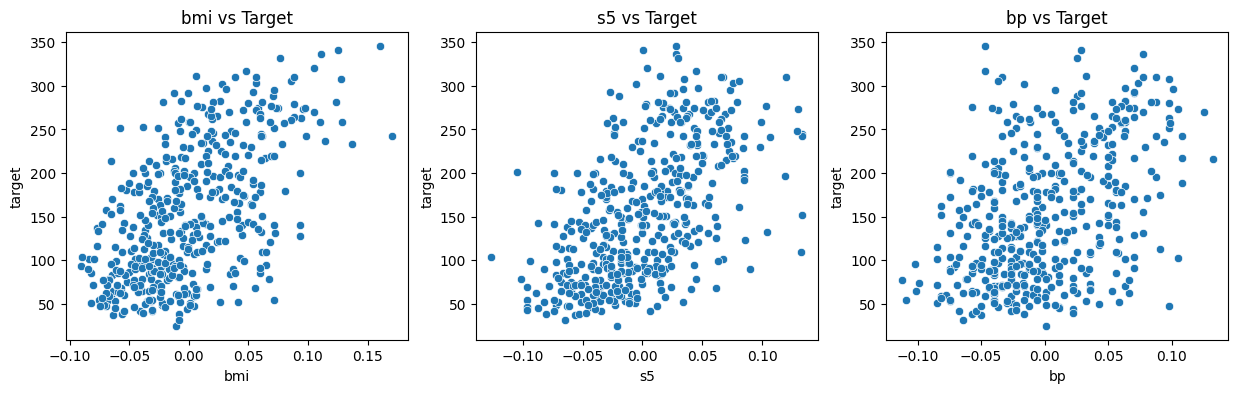

In [267]:
## do it in a loop to avoid repeating code
top_features = correlation_matrix["target"].drop("target").abs().sort_values(ascending=False).head(3).index.tolist()

plt.figure(figsize=(15, 4))
for i, feature in enumerate(top_features):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=df, x=feature, y="target")
    plt.title(f"{feature} vs Target")


plt.show()

Histogram:

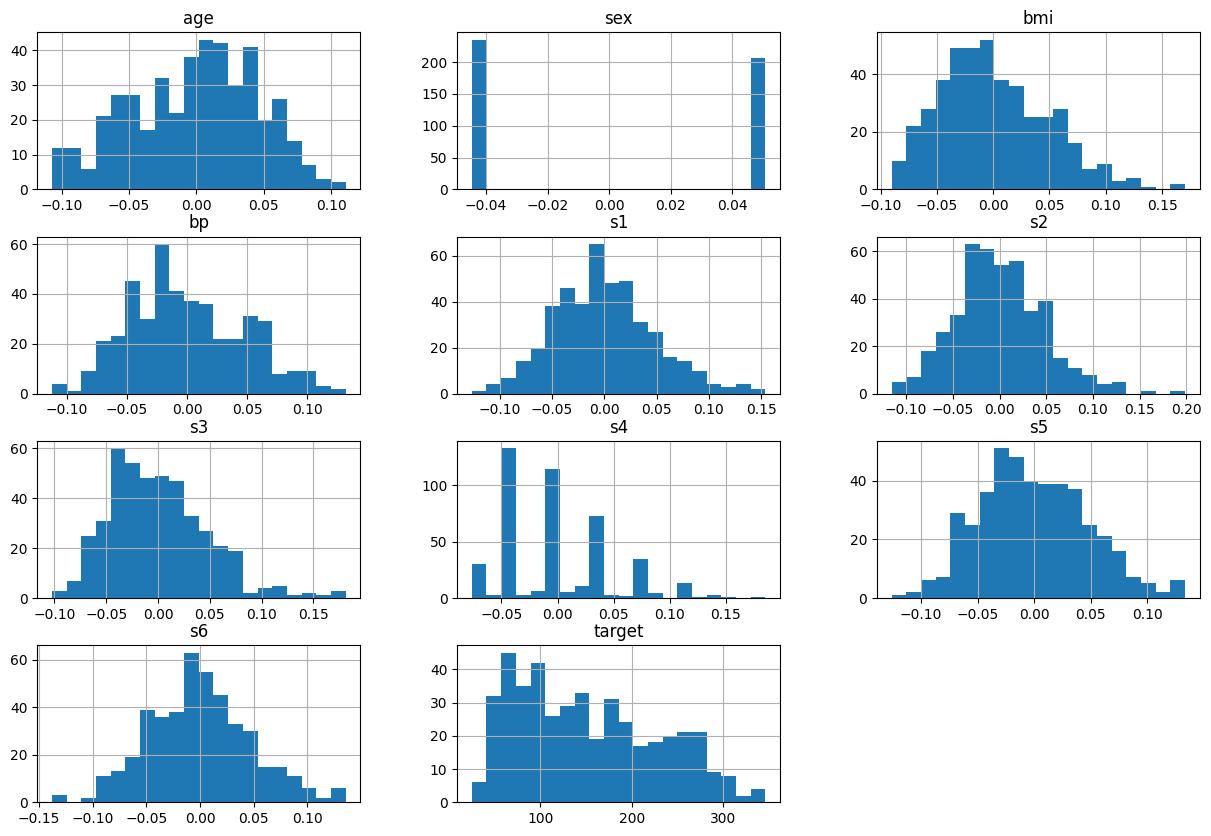

In [268]:
df.hist(bins=20, figsize=(15, 10))
plt.show()

Heat Map:

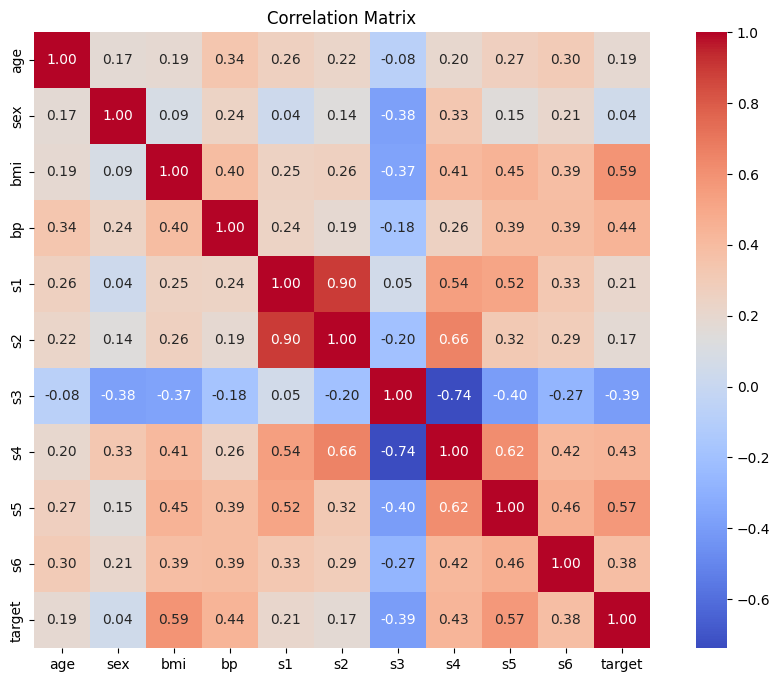

In [269]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

## Insights based on your EDA plots:

1. BMI is strongly correlated with disease progression:

    The scatter plot of BMI vs. target (disease progression) shows a clear positive trend, indicating that higher BMI values are associated with increased disease progression.

    The correlation matrix confirms this with a strong correlation coefficient of 0.59 between BMI and the target variable — one of the highest correlations observed.

2. Other significant features include S5 and BP:

    S5 shows a strong positive correlation (0.57) with the target.

    Blood Pressure (bp) also shows a moderate positive correlation (0.44), suggesting it’s a relevant predictor.

3. Feature distributions are standardized and mostly symmetric:

    Most features like age, bmi, bp, and s1–s6 are centered around 0 due to standardization, with fairly normal distributions.

    The target variable (disease progression) is right-skewed, indicating more cases with lower progression values and fewer extreme progression cases.

4. Some features are highly correlated with each other:

    S1 and S2 (both likely related to cholesterol or serum levels) have a very strong positive correlation (0.9), indicating multicollinearity.

    S3 and S4 are negatively correlated (-0.74), which may impact model interpretation.

Data Cleaning

In [270]:
df.isnull().sum()  # Check for missing values
##No missing values; no obvious outliers in EDA — no cleaning needed.

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

Let's check for outliers:

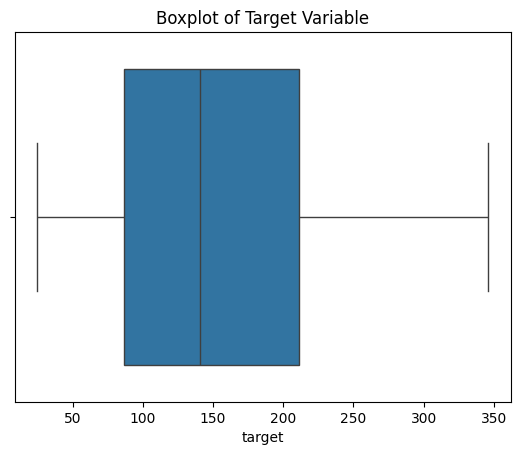

In [271]:
sns.boxplot(x=df["target"])
plt.title("Boxplot of Target Variable")
plt.show()

## Split Data Into Train, Validation, and Test

In [272]:
# Separate features and target
X = df.drop(columns='target')
y = df['target']

# Train (75%), validation (10%), test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.10/0.85, random_state=42)

print(f'Train: {X_train.shape[0]} samples')
print(f'Validation: {X_val.shape[0]} samples')
print(f'Test: {X_test.shape[0]} samples')


Train: 330 samples
Validation: 45 samples
Test: 67 samples


### Part 2: Univariate Polynomial Regression on BMI

Polynomial Regression Models (degrees 0 to 5)

In [273]:
# Only BMI feature
X_train_bmi = X_train[['bmi']]
X_val_bmi = X_val[['bmi']]
X_test_bmi = X_test[['bmi']]

results = []

for degree in range(6):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train_bmi)
    X_val_poly = poly.transform(X_val_bmi)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    
    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mape_val = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
    
    results.append({
        'Degree': degree,
        'R2Train': r2_train,
        'R2Val': r2_val,
        'MAEVal': mae_val,
        'MAPEVal': mape_val
    })
    
results_df = pd.DataFrame(results)
print(results_df)

print(results_df.columns.tolist())


   Degree   R2Train     R2Val     MAEVal    MAPEVal
0       0  0.000000 -0.000011  63.447475  58.793283
1       1  0.354240  0.449292  41.997581  40.444999
2       2  0.354771  0.449158  41.757683  40.309938
3       3  0.355002  0.447291  41.741042  40.258961
4       4  0.357983  0.449064  41.952846  40.240642
5       5  0.358910  0.453513  42.083400  40.340475
['Degree', 'R2Train', 'R2Val', 'MAEVal', 'MAPEVal']


### Identifing the best model


In [274]:
# Find the degree with the highest validation R²
best_deg = results_df.sort_values(by=['R2Val', 'MAEVal'], ascending=[False,True]).iloc[0]
best_degree_value = int(best_deg['Degree'])
print(f"Best model: Degree {best_degree_value}")

Best model: Degree 5


Based on highest R2 Val and lowest MAPE Val - Degree 5 looks good

Run on Test Set

In [275]:
# Using the best degree
poly_best = PolynomialFeatures(degree=best_degree_value)
X_train_poly = poly_best.fit_transform(X_train_bmi)
X_test_poly = poly_best.transform(X_test_bmi)

model_best = LinearRegression()
model_best.fit(X_train_poly, y_train)

y_test_pred = model_best.predict(X_test_poly)

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"R2 Test: {r2_test:.3f}, MAE Test: {mae_test:.2f}, MAPE Test: {mape_test:.2f}%")


R2 Test: 0.197, MAE Test: 54.55, MAPE Test: 47.88%


Plot Train, Val, Test vs Model

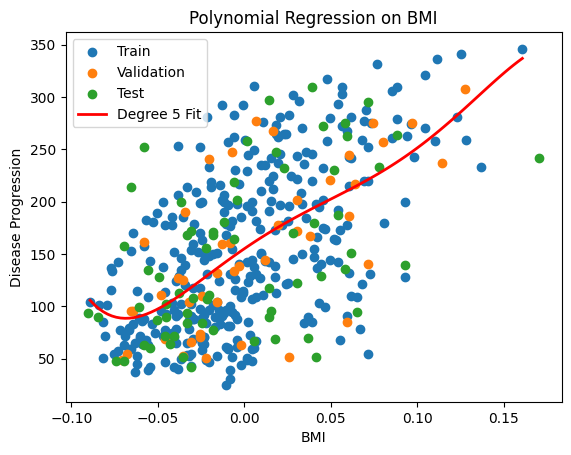

In [276]:
# Plot BMI vs Disease progression
plt.scatter(X_train_bmi, y_train, label='Train')
plt.scatter(X_val_bmi, y_val, label='Validation')
plt.scatter(X_test_bmi, y_test, label='Test')

# Line of best fit
bmi_range = np.linspace(X_train_bmi.min(), X_train_bmi.max(), 100).reshape(-1, 1)
bmi_range_df = pd.DataFrame(bmi_range, columns=['bmi'])

bmi_poly = poly_best.transform(bmi_range_df)
y_fit = model_best.predict(bmi_poly)
plt.plot(bmi_range, y_fit, color='red', linewidth=2, label=f'Degree {best_degree_value} Fit')

plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.legend()
plt.title('Polynomial Regression on BMI')
plt.show()


Equation of Best Model

In [277]:
poly_best = PolynomialFeatures(degree=best_degree_value)
X_train_poly = poly_best.fit_transform(X_train[['bmi']])

model_best = LinearRegression()
model_best.fit(X_train_poly, y_train)

# Get intercept and coefficients
intercept = model_best.intercept_
coefficients = model_best.coef_

# Print equation
feature_names = poly_best.get_feature_names_out(['bmi'])

print(f"Intercept: {intercept:.2f}")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.2f}")

Intercept: 155.08
1: 0.00
bmi: 1131.59
bmi^2: -3946.02
bmi^3: -26110.86
bmi^4: 768725.87
bmi^5: -2823251.97


### Predict for Custom BMI Value

In [278]:
bmi_mean_value = X_train_bmi['bmi'].mean()
print(f"Mean BMI value: {bmi_mean_value:.4f}")
bmi_input_df = pd.DataFrame({'bmi': [bmi_mean_value]})
custom_bmi_poly = poly_best.transform(bmi_input_df)
predicted_progression = model_best.predict(custom_bmi_poly)
print(f"Predicted progression for BMI={bmi_mean_value:.4f}: {predicted_progression[0]:.2f}")


Mean BMI value: -0.0001
Predicted progression for BMI=-0.0001: 154.97


 Trainable Parameters

In [279]:
# Number of features in the transformed polynomial space
poly_best.get_feature_names_out(['bmi'])


array(['1', 'bmi', 'bmi^2', 'bmi^3', 'bmi^4', 'bmi^5'], dtype=object)

## conclusion 

The best performing model was a univariate polynomial regression of degree 5, trained on the BMI feature. The model equation included 6 parameters: intercept + bmi + bmi² + bmi³ + bmi⁴ + bmi⁵. 

The predicted disease progression for a patient with mean BMI = -0.0001 was 154.97. The model fits well in the mid-range of BMI values but may overfit at extreme BMI values due to the high degree. 

Limitations: The model uses only BMI as the input feature, which restricts its ability to capture the complexity of diabetes progression. Other clinical factors such as age, blood pressure, and glucose levels are not considered here. Including these features could improve prediction accuracy and generalization. Additionally, the degree 5 polynomial risks overfitting, which could be mitigated with regularization or model selection through cross-validation.

### Part 3: Multivariate Models

Prepare All Features

In [280]:
# Use all X columns
X_train_poly = PolynomialFeatures(degree=2).fit_transform(X_train)
X_val_poly = PolynomialFeatures(degree=2).fit_transform(X_val)
X_test_poly = PolynomialFeatures(degree=2).fit_transform(X_test)

# Model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Evaluate...
# (Repeat similar to Part 2)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False
